# IND320 – Project Part 2 : Elhub Data Analysis
## *Welcome to my Project work, part 2 - Data Sources*
### Author : Jules Sylvain MUAMBA MVELE
### Description :
This notebook demonstrates the Elhub data analysis workflow for 2021.
It includes :
- Data ingestion from Elhub (CSV or API)
- Storage in Cassandra and MongoDB
- Visualizations (pie chart and line chart)
- Documentation of AI assistance and work log

**!! I created a nez branch named part2**


### Links

- **GitHub Repository:** [https://github.com/JulesSylMUAMBA/IND320_DataTo_Decision/tree/part2](https://github.com/JulesSylMUAMBA/IND320_DataTo_Decision/tree/part2)
- **Streamlit App:** https://ind320datatodecision-m8z5c8kxibzrnoy2parjfq.streamlit.app/


## AI usage 

During this project, I used AI tools (mainly ChatGPT) as a programming assistant and technical explainer.  
The main tasks where AI was used include:
- Debugging issues with Python environments (especially Cassandra and package dependencies).
- Translating comments and explanations from French to English.
- Writing clearly commented code that can be understood by others.
- Structuring the project pipeline (Cassandra → MongoDB → Streamlit).
- Clarifying the course requirements and how to implement them in a practical way.

The AI was **not used to automatically generate the final results**, but as a guide to understand, fix, and organize the code.  
All code was tested and adapted manually.  
This use of AI helped improve productivity and understanding without replacing independent work.


## Part 1 : Diagnostic and Troubleshooting – Spark & Cassandra Configuration on Windows

During the setup of the Spark + Cassandra environment, several technical issues were encountered.
This section documents the problems, the attempted fixes, and the final working configuration, it's not working anyway, i'm open to any help.
I tried a lot of things for days, hope it's clear enough to understand (even if it's not clear for me anymore haha).

### Initial Context

The goal was to run a Jupyter (Python) notebook capable of:

Starting a local Spark 3.5.1 session

Connecting to Cassandra 5.0 running in a Docker container

Using the connector spark-cassandra-connector_2.12-3.5.1.jar

System setup: Windows 11, Anaconda, environment IND320_env, Java JDK 17 (Temurin).

### Problems Encountered

#### **1. Error ModuleNotFoundError: No module named 'pyspark'**

- Cause: The PySpark package was not installed in the conda environment.
- Solution: "pip install pyspark"


#### **2. Error PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number**

- Error appeared when launching Spark: "from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Test").getOrCreate()"
- Analysis:

Communication issue between Python and the JVM

Missing environment variables: JAVA_HOME, HADOOP_HOME, SPARK_HOME

Missing winutils on Windows
- Complete Solution:

Manually install Hadoop winutils (v3.3.1) from the kontext-tech/winutils repository

Download and extract Spark 3.5.1 prebuilt for Hadoop 3 into C:\spark\spark-3.5.1-bin-hadoop3

Set the environment variables: 
```
import os

os.environ["SPARK_HOME"] = r"C:\spark\spark-3.5.1-bin-hadoop3"
os.environ["HADOOP_HOME"] = r"C:\Hadoop\hadoop-3.3.1"
os.environ["JAVA_HOME"] = r"C:\Program Files\Eclipse Adoptium\jdk-17.0.13.11-hotspot"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"
os.environ["JAVA_TOOL_OPTIONS"] = "-Djava.net.preferIPv4Stack=true"

```

- Test with: "%SPARK_HOME%\bin\spark-submit.cmd --version"
- Result : "Spark 3.5.1 runs successfully with Scala 2.12.18 and Java 17."

#### **3. Error TypeError: 'JavaPackage' object is not callable**

- Cause: Spark environment not properly initialized or incorrect path.
- Solution: Explicitly define SPARK_HOME and use findspark for diagnostics.

#### **4. Hadoop-related error: /tmp not accessible**

- Cause: Spark on Windows requires a valid /tmp directory with proper permissions.
- Solution:
```
import os, subprocess
os.makedirs(r"C:\tmp", exist_ok=True)
subprocess.run(r'C:\Hadoop\hadoop-3.3.1\bin\winutils.exe chmod 777 /tmp', shell=True)

```

- Spark starts without warnings.

#### **5. Spark–Cassandra Connector Compatibility Error**

- Cause: The connector was not automatically downloaded.
- Solution: Manually download et and configure explicitly::
```
spark-cassandra-connector_2.12-3.5.1.jar
.config('spark.jars', r'C:\...\spark-cassandra-connector_2.12-3.5.1.jar')

```

#### **Lessons Learned**

On Windows, Spark requires Java + Hadoop (winutils) + IPv4 configuration.

The JAVA_GATEWAY_EXITED error is almost always caused by incorrect environment settings.

Testing Spark via spark-submit.cmd --version before using PySpark in Jupyter helps isolate configuration issues.

Version compatibility between Spark (3.5.1), Scala (2.12), and the Cassandra connector is essential.

_

### Final Config tried

In [1]:
import os

# --- Spark and Cassandra paths ---
os.environ["SPARK_HOME"] = r"C:\spark\spark-3.5.1-bin-hadoop3"
jar_path = r"C:\Users\muamb\Desktop\ESILV\2025-2026\NMBU\Cours\IND320_DataToDecision\spark-cassandra-connector_2.12-3.5.1.jar"

# --- Force Spark to include the JAR in the classpath ---
os.environ["PYSPARK_SUBMIT_ARGS"] = f'--jars "{jar_path}" pyspark-shell'

# --- Java and Hadoop ---
os.environ["JAVA_HOME"] = r"C:\Program Files\Eclipse Adoptium\jdk-17.0.13.11-hotspot"
os.environ["HADOOP_HOME"] = r"C:\Hadoop\hadoop-3.3.1"
os.environ["PATH"] = (
    os.environ["JAVA_HOME"] + r"\bin;"
    + os.environ["HADOOP_HOME"] + r"\bin;"
    + os.environ["SPARK_HOME"] + r"\bin;"
    + os.environ["PATH"]
)

# --- IPv4 / Python configuration ---
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"
os.environ["JAVA_TOOL_OPTIONS"] = "-Djava.net.preferIPv4Stack=true"
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

print("Spark environment + Cassandra ready.")


Spark environment + Cassandra ready.


In [2]:
import os, subprocess
os.makedirs(r"C:\tmp", exist_ok=True)
subprocess.run(r'C:\Hadoop\hadoop-3.3.1\bin\winutils.exe chmod 777 /tmp', shell=True, check=False)
print("winutils chmod done")


winutils chmod done


import os, findspark
# check for Spark on notebook
os.environ["SPARK_HOME"] = r"C:\spark\spark-3.5.1-bin-hadoop3"
findspark.init(os.environ["SPARK_HOME"])  # <-- clé
print("findspark OK ->", findspark.find())


import os, sys, findspark

# --- Local paths ---
SPARK_HOME  = r"C:\spark\spark-3.5.1-bin-hadoop3"
JAVA_HOME   = r"C:\Program Files\Eclipse Adoptium\jdk-17.0.13.11-hotspot"
HADOOP_HOME = r"C:\Hadoop\hadoop-3.3.1"

# Cassandra JARs (assembly + driver)
jar_main   = r"C:\Users\muamb\Desktop\ESILV\2025-2026\NMBU\Cours\IND320_DataToDecision\spark-cassandra-connector-assembly_2.12-3.5.1.jar"
jar_driver = r"C:\Users\muamb\Desktop\ESILV\2025-2026\NMBU\Cours\IND320_DataToDecision\spark-cassandra-connector-driver_2.12-3.5.1.jar"
all_jars   = f"{jar_main},{jar_driver}"

# --- Environment variables for Spark / Java / Hadoop / Python ---
os.environ["SPARK_HOME"]  = SPARK_HOME
os.environ["JAVA_HOME"]   = JAVA_HOME
os.environ["HADOOP_HOME"] = HADOOP_HOME
os.environ["PATH"] = (
    SPARK_HOME + r"\bin;"
    + HADOOP_HOME + r"\bin;"
    + JAVA_HOME + r"\bin;"
    + os.environ["PATH"]
)

# Force PySpark to use the current Python interpreter (important on Windows)
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Network configuration (Windows)
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"
os.environ["JAVA_TOOL_OPTIONS"] = "-Djava.net.preferIPv4Stack=true"

# Load JARs on both driver and executors (also through submit args)
os.environ["PYSPARK_SUBMIT_ARGS"] = f'--jars "{all_jars}" pyspark-shell'

# Initialize Spark with findspark
findspark.init(SPARK_HOME)

from pyspark.sql import SparkSession

# --- Create Spark Session ---
spark = (
    SparkSession.builder
    .master("local[1]")  # More stable on Windows
    .appName("SparkCassandraApp")
    .config("spark.cassandra.connection.host", "localhost")  # Docker Desktop → Cassandra
    .config("spark.cassandra.connection.port", "9042")
    .config("spark.sql.execution.arrow.pyspark.enabled", "false")
    .config("spark.python.worker.reuse", "false")
    .config("spark.driver.extraClassPath", all_jars)
    .config("spark.executor.extraClassPath", all_jars)
    .getOrCreate()
)

print("✅ Spark initialized — version:", spark.version)
print("✅ Spark JARs:", spark.sparkContext.getConf().get("spark.jars"))


print("JARs used :", spark.sparkContext._conf.get("spark.jars"))


In [10]:
import socket
print(socket.gethostbyname("localhost"))


127.0.0.1


In [11]:
import socket
s = socket.socket()
s.settimeout(2)
try:
    s.connect(("localhost", 9042))
    print("Cassandra is on 9042")
except Exception as e:
    print(" Cassandra not avaible", e)
s.close()


Cassandra is on 9042


import os

os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"
os.environ["JAVA_TOOL_OPTIONS"] = "-Djava.net.preferIPv4Stack=true"
os.environ["HADOOP_HOME"] = r"C:\Hadoop\hadoop-3.3.1"
os.environ["PATH"] = os.environ["HADOOP_HOME"] + r"\bin;" + os.environ["PATH"]


import os, sys
from pyspark.sql import SparkSession

PYTHON_EXE = r"C:\Users\muamb\anaconda3\envs\IND320_env\python.exe"
os.environ["PYSPARK_PYTHON"] = PYTHON_EXE
os.environ["PYSPARK_DRIVER_PYTHON"] = PYTHON_EXE
for bad in ("PYTHONHOME", "PYTHONPATH"):
    os.environ.pop(bad, None)
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"
os.environ["JAVA_TOOL_OPTIONS"] = "-Djava.net.preferIPv4Stack=true"

spark = (SparkSession.builder
    .master("local[1]")
    .appName("worker-smoke-test")
    .config("spark.sql.execution.arrow.pyspark.enabled", "false")
    .getOrCreate())

print("✅ Spark:", spark.version)
print("✅ Python:", sys.executable)
print("➡️ Test workers =", spark.sparkContext.parallelize(range(10)).count())


### **Main Errors**

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
Cell In[17], line 20
     18 print("✅ Spark:", spark.version)
     19 print("✅ Python:", sys.executable)
---> 20 print("➡️ Test workers =", spark.sparkContext.parallelize(range(10)).count())

File C:\spark\spark-3.5.1-bin-hadoop3\python\pyspark\rdd.py:2316, in RDD.count(self)
   2295 def count(self) -> int:
   2296     """
   2297     Return the number of elements in this RDD.
   2298 
   (...)   2314     3
   2315     """
-> 2316     return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()

File C:\spark\spark-3.5.1-bin-hadoop3\python\pyspark\rdd.py:2291, in RDD.sum(self)
   2270 def sum(self: "RDD[NumberOrArray]") -> "NumberOrArray":
   2271     """
   2272     Add up the elements in this RDD.
   2273 
   (...)   2289     6.0
   2290     """
-> 2291     return self.mapPartitions(lambda x: [sum(x)]).fold(  # type: ignore[return-value]
   2292         0, operator.add
   2293     )

File C:\spark\spark-3.5.1-bin-hadoop3\python\pyspark\rdd.py:2044, in RDD.fold(self, zeroValue, op)
   2039     yield acc
   2041 # collecting result of mapPartitions here ensures that the copy of
   2042 # zeroValue provided to each partition is unique from the one provided
   2043 # to the final reduce call
-> 2044 vals = self.mapPartitions(func).collect()
   2045 return reduce(op, vals, zeroValue)

File C:\spark\spark-3.5.1-bin-hadoop3\python\pyspark\rdd.py:1833, in RDD.collect(self)
   1831 with SCCallSiteSync(self.context):
   1832     assert self.ctx._jvm is not None
-> 1833     sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
   1834 return list(_load_from_socket(sock_info, self._jrdd_deserializer))

File C:\spark\spark-3.5.1-bin-hadoop3\python\lib\py4j-0.10.9.7-src.zip\py4j\java_gateway.py:1322, in JavaMember.__call__(self, *args)
   1316 command = proto.CALL_COMMAND_NAME +\
   1317     self.command_header +\
   1318     args_command +\
   1319     proto.END_COMMAND_PART
   1321 answer = self.gateway_client.send_command(command)
-> 1322 return_value = get_return_value(
   1323     answer, self.gateway_client, self.target_id, self.name)
   1325 for temp_arg in temp_args:
   1326     if hasattr(temp_arg, "_detach"):

File C:\spark\spark-3.5.1-bin-hadoop3\python\pyspark\errors\exceptions\captured.py:179, in capture_sql_exception.<locals>.deco(*a, **kw)
    177 def deco(*a: Any, **kw: Any) -> Any:
    178     try:
--> 179         return f(*a, **kw)
    180     except Py4JJavaError as e:
    181         converted = convert_exception(e.java_exception)

File C:\spark\spark-3.5.1-bin-hadoop3\python\lib\py4j-0.10.9.7-src.zip\py4j\protocol.py:326, in get_return_value(answer, gateway_client, target_id, name)
    324 value = OUTPUT_CONVERTER[type](answer[2:], gateway_client)
    325 if answer[1] == REFERENCE_TYPE:
--> 326     raise Py4JJavaError(
    327         "An error occurred while calling {0}{1}{2}.\n".
    328         format(target_id, ".", name), value)
    329 else:
    330     raise Py4JError(
    331         "An error occurred while calling {0}{1}{2}. Trace:\n{3}\n".
    332         format(target_id, ".", name, value))

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 1.0 failed 1 times, most recent failure: Lost task 9.0 in stage 1.0 (TID 21) (kubernetes.docker.internal executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:386)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)

In [12]:
import sys, platform
print("Python:", sys.executable)
print("Version:", platform.python_version())


Python: C:\Users\muamb\anaconda3\envs\IND320_py311\python.exe
Version: 3.11.14


#

#

## Part 2 : Work without Spark

### Install all the dependencies

In [6]:
!pip install pandas cassandra-driver pymongo requests matplotlib plotly tqdm python-dotenv


### Importations

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from pymongo import MongoClient
from tqdm import tqdm

print("✅ All modules imported successfully!")


✅ All modules imported successfully!


### Test of connection

In [8]:
# --- Imports ---
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider  # only if your Cassandra requires authentication
from cassandra.query import SimpleStatement

# --- Connection settings ---
CASSANDRA_HOST = "localhost"
CASSANDRA_PORT = 9042


CASSANDRA_USER = None  
CASSANDRA_PASS = None   

KEYSPACE = "ind320"
TABLE    = "elhub_data_test"  # just a temporary test table


In [13]:
# --- Connect to Cassandra cluster ---
try:
    if CASSANDRA_USER and CASSANDRA_PASS:
        auth_provider = PlainTextAuthProvider(
            username=CASSANDRA_USER, password=CASSANDRA_PASS
        )
        cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT, auth_provider=auth_provider)
    else:
        cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)

    session = cluster.connect()
    print("✅ Connected to Cassandra")
except Exception as e:
    raise SystemExit(f"❌ Unable to connect to Cassandra: {e}")


✅ Connected to Cassandra


In [14]:
# --- Create keyspace if it does not exist ---
session.execute(f"""
CREATE KEYSPACE IF NOT EXISTS {KEYSPACE}
WITH replication = {{'class': 'SimpleStrategy', 'replication_factor': 1}};
""")

# --- Switch to the new keyspace ---
session.set_keyspace(KEYSPACE)

# --- Create a simple test table ---
session.execute(f"""
CREATE TABLE IF NOT EXISTS {TABLE} (
    id int PRIMARY KEY,
    txt text
);
""")

print(f"✅ Keyspace `{KEYSPACE}` and table `{TABLE}` are ready.")


✅ Keyspace `ind320` and table `elhub_data_test` are ready.


In [15]:
# Sanity check 
# --- Read without ORDER BY and sort in Python ---
rows = session.execute(f"SELECT id, txt FROM {TABLE};")
rows_sorted = sorted(rows, key=lambda r: r.id)  # sort locally in Python

print("📄 Rows in the test table (sorted client-side):")
for r in rows_sorted:
    print(r)


📄 Rows in the test table (sorted client-side):
Row(id=1, txt='hello')
Row(id=2, txt='world')
Row(id=3, txt='ind320')


## Load Data

### Load the Data from API

In [30]:
# --- Elhub Energy Data API (v0 public) — 2021 monthly fetch with fixed +02:00 offset ---
# Endpoint shape:
#   https://api.elhub.no/energy-data/v0/price-areas?dataset=PRODUCTION_PER_GROUP_MBA_HOUR&startDate=...&endDate=...
# We extract ONLY 'productionPerGroupMbaHour' and build a clean DataFrame with 4 columns.

import requests
import pandas as pd
from datetime import datetime, timedelta
import time

BASE_URL = "https://api.elhub.no/energy-data/v0/price-areas"
DATASET = "PRODUCTION_PER_GROUP_MBA_HOUR"
YEAR = 2021

# Elhub expects the '+' sign URL-encoded in the offset. We'll append this to the timestamp string.
# We deliberately use a CONSTANT +02:00 for the whole year, which is accepted by the v0 endpoint and avoids DST 400 errors.
TZ_OFFSET_ENC = "%2B02:00"  # '+02:00' URL-encoded

def month_ranges(year: int):
    """Return list of (start_local, end_local) naive datetimes covering each month of the given year."""
    ranges = []
    for m in range(1, 13):
        start_local = datetime(year, m, 1, 0, 0, 0)
        if m == 12:
            end_local = datetime(year, 12, 31, 23, 0, 0)
        else:
            end_local = datetime(year, m + 1, 1, 0, 0, 0) - timedelta(hours=1)
        ranges.append((start_local, end_local))
    return ranges

def fmt_with_fixed_offset(dt_local: datetime) -> str:
    """Format naive local datetime as ISO without timezone, then append '+02:00' (URL-encoded)."""
    return dt_local.strftime("%Y-%m-%dT%H:%M:%S") + TZ_OFFSET_ENC

def fetch_month(start_local: datetime, end_local: datetime):
    """Fetch one month safely and return the raw records from 'productionPerGroupMbaHour'."""
    start_str = fmt_with_fixed_offset(start_local)
    end_str   = fmt_with_fixed_offset(end_local)
    url = f"{BASE_URL}?dataset={DATASET}&startDate={start_str}&endDate={end_str}"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    js = r.json()

    # Collect only the list from attributes.productionPerGroupMbaHour
    records = []
    for entity in js.get("data", []):
        attrs = entity.get("attributes") or {}
        recs = attrs.get("productionPerGroupMbaHour", [])
        records.extend(recs)
    return records

# --- Fetch all months of 2021 ---
all_records = []
for (start_local, end_local) in month_ranges(YEAR):
    try:
        recs = fetch_month(start_local, end_local)
        print(f"{start_local:%Y-%m}: {len(recs)} records")
        all_records.extend(recs)
        time.sleep(0.3)  # polite delay
    except Exception as e:
        print(f"⚠️ {start_local:%Y-%m} failed: {e}")

# --- Normalize to DataFrame with the required schema ---
if not all_records:
    df = pd.DataFrame(columns=["price_area", "production_group", "start_time", "quantity_kwh"])
else:
    df = pd.json_normalize(all_records).rename(columns={
        "priceArea": "price_area",
        "productionGroup": "production_group",
        "startTime": "start_time",
        "quantityKwh": "quantity_kwh",
    })
    # Parse timestamps to UTC-aware (the source strings include +02:00, pandas will convert to UTC if utc=True)
    df["start_time"] = pd.to_datetime(df["start_time"], utc=True, errors="coerce")
    df = df[["price_area", "production_group", "start_time", "quantity_kwh"]]

print("✅ API 2021 shape:", df.shape)
df.head()


2021-01: 17832 records
2021-02: 16104 records
2021-03: 17808 records
2021-04: 17256 records
2021-05: 17832 records
2021-06: 17951 records
2021-07: 18575 records
2021-08: 18575 records
2021-09: 17975 records
2021-10: 18600 records
2021-11: 17975 records
2021-12: 18575 records
✅ API 2021 shape: (215058, 4)


,price_area,production_group,start_time,quantity_kwh
0,NO1,hydro,2020-12-31 23:00:00+00:00,2507716.8
1,NO1,hydro,2021-01-01 00:00:00+00:00,2494728.0
2,NO1,hydro,2021-01-01 01:00:00+00:00,2486777.5
3,NO1,hydro,2021-01-01 02:00:00+00:00,2461176.0
4,NO1,hydro,2021-01-01 03:00:00+00:00,2466969.2


In [31]:
df.tail()


,price_area,production_group,start_time,quantity_kwh
215053,NO5,wind,2021-12-31 17:00:00+00:00,0.0
215054,NO5,wind,2021-12-31 18:00:00+00:00,0.0
215055,NO5,wind,2021-12-31 19:00:00+00:00,0.0
215056,NO5,wind,2021-12-31 20:00:00+00:00,0.0
215057,NO5,wind,2021-12-31 21:00:00+00:00,0.0


### Minimal cleaning 

In [32]:
# --- Light cleaning: types, missing values, duplicates ---
df = df.dropna(subset=["start_time", "price_area", "production_group", "quantity_kwh"]).copy()

df["price_area"] = df["price_area"].astype("string").str.strip()
df["production_group"] = df["production_group"].astype("string").str.strip()
df["quantity_kwh"] = pd.to_numeric(df["quantity_kwh"], errors="coerce")

n_before = len(df)
df = df.drop_duplicates(subset=["price_area", "production_group", "start_time"], keep="last")
print(f"🧹 Removed {n_before - len(df)} duplicated hourly rows.")

print("✅ Clean DataFrame shape:", df.shape)
df.head()


🧹 Removed 0 duplicated hourly rows.
✅ Clean DataFrame shape: (215058, 4)


,price_area,production_group,start_time,quantity_kwh
0,NO1,hydro,2020-12-31 23:00:00+00:00,2507716.8
1,NO1,hydro,2021-01-01 00:00:00+00:00,2494728.0
2,NO1,hydro,2021-01-01 01:00:00+00:00,2486777.5
3,NO1,hydro,2021-01-01 02:00:00+00:00,2461176.0
4,NO1,hydro,2021-01-01 03:00:00+00:00,2466969.2


In [33]:
# --- Quick sanity stats for documentation/log ---
print("Price areas:", sorted(df["price_area"].dropna().unique().tolist()))
print("Production groups:", sorted(df["production_group"].dropna().unique().tolist()))
print("Date range (UTC):", df["start_time"].min(), "→", df["start_time"].max())

# --- Should be hourly frequency per area/group in 2021; quick check of counts ---
counts = df.groupby(["price_area", "production_group"]).size().reset_index(name="n_rows")
counts.sort_values("n_rows", ascending=False).head(10)


Price areas: ['NO1', 'NO2', 'NO3', 'NO4', 'NO5']
Production groups: ['hydro', 'other', 'solar', 'thermal', 'wind']
Date range (UTC): 2020-12-31 23:00:00+00:00 → 2021-12-31 21:00:00+00:00


,price_area,production_group,n_rows
0,NO1,hydro,8748
1,NO1,other,8748
2,NO1,solar,8748
3,NO1,thermal,8748
4,NO1,wind,8748
5,NO2,hydro,8748
6,NO2,other,8748
7,NO2,solar,8748
8,NO2,thermal,8748
9,NO2,wind,8748


### Create Cassandra table (final schema) + insert batches

#### Creating the final table (key: (price_area, production_group), clustering: start_time)

In [34]:
# --- Create final Cassandra table for Elhub hourly production ---
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

CASSANDRA_HOST = "localhost"
CASSANDRA_PORT = 9042
KEYSPACE = "ind320"
TABLE = "production_mba_hour"  # unified naming with MongoDB

cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
session = cluster.connect()

# --- Ensure keyspace exists (if not already created earlier) ---
session.execute(f"""
CREATE KEYSPACE IF NOT EXISTS {KEYSPACE}
WITH replication = {{ 'class': 'SimpleStrategy', 'replication_factor': 1 }};
""")

session.set_keyspace(KEYSPACE)

# --- Create the final table (partitioned by price_area + production_group) ---
session.execute(f"""
CREATE TABLE IF NOT EXISTS {TABLE} (
    price_area text,
    production_group text,
    start_time timestamp,
    quantity_kwh double,
    PRIMARY KEY ((price_area, production_group), start_time)
) WITH CLUSTERING ORDER BY (start_time ASC);
""")

print(f"✅ Cassandra table `{KEYSPACE}.{TABLE}` ready.")


✅ Cassandra table `ind320.production_mba_hour` ready.


In [35]:
# --- Optional year filter: keep only a given year if present ---
TARGET_YEAR = 2021  # change to 2022/2023/etc. or set to None for "no filter"

df_to_load = df.copy()
if TARGET_YEAR is not None:
    mask = df_to_load["start_time"].dt.year == TARGET_YEAR
    if mask.any():
        df_to_load = df_to_load[mask].copy()
        print(f"ℹ️ Using only rows for year {TARGET_YEAR}: {len(df_to_load)} rows.")
    else:
        print(f"⚠️ No rows found for year {TARGET_YEAR}. Proceeding with ALL rows: {len(df_to_load)} rows.")
else:
    print(f"ℹ️ No year filter. Proceeding with ALL rows: {len(df_to_load)} rows.")


ℹ️ Using only rows for year 2021: 215034 rows.


In [36]:
# --- Fast concurrent insert into Cassandra (no Spark) ---
# We use a PreparedStatement + execute_concurrent_with_args for high-throughput writes.
from cassandra.query import PreparedStatement
from cassandra.concurrent import execute_concurrent_with_args
from cassandra import ConsistencyLevel
from tqdm import tqdm
import math

# 1) Choose the DataFrame to load
df_to_load = df  # if your variable is already named df

# 2) Optional: small sanitation to ensure correct types
df_to_load = df_to_load.dropna(subset=["price_area", "production_group", "start_time", "quantity_kwh"]).copy()
df_to_load["price_area"] = df_to_load["price_area"].astype(str)
df_to_load["production_group"] = df_to_load["production_group"].astype(str)
# Ensure pandas timestamps become native datetimes for the driver
df_to_load["start_time"] = pd.to_datetime(df_to_load["start_time"], utc=True, errors="coerce")

# 3) Prepare the INSERT statement once (faster and safer)
insert_ps: PreparedStatement = session.prepare(f"""
    INSERT INTO {TABLE} (price_area, production_group, start_time, quantity_kwh)
    VALUES (?, ?, ?, ?)
""")
# (Optional) set a relaxed consistency if you write to a single-node dev cluster
insert_ps.consistency_level = ConsistencyLevel.ONE

# 4) Convert DataFrame rows to the parameter tuples expected by the driver
def row_to_tuple(row):
    return (
        row["price_area"],
        row["production_group"],
        row["start_time"].to_pydatetime(),  # native datetime (UTC)
        float(row["quantity_kwh"])
    )

params = [row_to_tuple(row) for _, row in df_to_load.iterrows()]

# 5) Tune concurrency / chunking (Windows → start modest, increase if stable)
CONCURRENCY = 64          # try 64 → 128 → 256 if your machine handles it
BATCH_SIZE  = 20_000      # avoid massive single jobs; 10k–50k is fine here

total = len(params)
print(f"🚀 Inserting {total} rows into `{KEYSPACE}.{TABLE}` (concurrency={CONCURRENCY})")

errors_total = 0
for i in tqdm(range(0, total, BATCH_SIZE), desc="Batches"):
    chunk = params[i:i+BATCH_SIZE]
    results = execute_concurrent_with_args(
        session,
        insert_ps,
        chunk,
        concurrency=CONCURRENCY,
        raise_on_first_error=False  # collect errors instead of aborting at first
    )
    # Count failed writes in this chunk
    chunk_errors = sum(0 if ok else 1 for ok, _ in results)
    errors_total += chunk_errors

print(f"✅ Insert complete. Errors: {errors_total}")


🚀 Inserting 215058 rows into `ind320.production_mba_hour` (concurrency=64)


Batches: 100%|█████████████████████████████████████████████████████████████████████████| 11/11 [01:16<00:00,  6.98s/it]

✅ Insert complete. Errors: 0


In [37]:
# --- Quick counts per area/group (rough sanity check) ---
rows = session.execute(f"""
    SELECT price_area, production_group, count(*) as n
    FROM {TABLE}
    GROUP BY price_area, production_group
    ALLOW FILTERING;
""")
# Note: ALLOW FILTERING is okay here for small ad-hoc checks; avoid in prod.

print("Counts by (price_area, production_group):")
for r in rows:
    print(r)

# --- Sample read: pick one area/group and a small time window ---
sample_area = "NO1"
sample_group = "hydro"

rows = session.execute(f"""
    SELECT price_area, production_group, start_time, quantity_kwh
    FROM {TABLE}
    WHERE price_area = %s AND production_group = %s
    LIMIT 5;
""", (sample_area, sample_group))

print("\n Sample rows:")
for r in rows:
    print(r)


Counts by (price_area, production_group):
Row(price_area='NO3', production_group='wind', n=8748)
Row(price_area='NO4', production_group='wind', n=8748)
Row(price_area='NO3', production_group='hydro', n=8748)
Row(price_area='NO1', production_group='other', n=8748)
Row(price_area='NO4', production_group='hydro', n=8748)
Row(price_area='NO3', production_group='solar', n=8748)
Row(price_area='NO2', production_group='thermal', n=8748)
Row(price_area='NO5', production_group='wind', n=5106)
Row(price_area='NO1', production_group='thermal', n=8748)
Row(price_area='NO1', production_group='hydro', n=8748)
Row(price_area='NO5', production_group='solar', n=8748)
Row(price_area='NO2', production_group='solar', n=8748)
Row(price_area='NO4', production_group='thermal', n=8748)
Row(price_area='NO5', production_group='other', n=8748)
Row(price_area='NO2', production_group='wind', n=8748)
Row(price_area='NO4', production_group='other', n=8748)
Row(price_area='NO4', production_group='solar', n=8748)
Row(

### Read from Cassandra and plots (pie + line)

In [38]:
# --- Imports ---
import pandas as pd
from cassandra.cluster import Cluster
from cassandra.query import SimpleStatement

# --- Cassandra connection (reuse your settings if already connected) ---
CASSANDRA_HOST = "localhost"
CASSANDRA_PORT = 9042
KEYSPACE       = "ind320"
TABLE          = "production_mba_hour"  # unified name

cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
session = cluster.connect()
session.set_keyspace(KEYSPACE)

# Optional: tune default fetch size to stream results in chunks (avoid big memory bursts)
session.default_fetch_size = 5_000

# --- Known production groups (observed in the dataset) ---
# Note: '*' is an aggregate bucket; exclude it by default for charts.
KNOWN_GROUPS = ["hydro", "wind", "solar", "thermal", "other"]  # no '*'

def fetch_area_data(session, table, price_area, groups=None):
    """
    Fetch all rows for a given price area across the chosen production groups.
    Because of the Cassandra primary key ((price_area, production_group), start_time),
    we must query per (price_area, production_group).
    Returns a pandas DataFrame with columns:
      ['price_area','production_group','start_time','quantity_kwh'] sorted by time.
    """
    if groups is None:
        groups = KNOWN_GROUPS

    rows_all = []
    for g in groups:
        if not g:
            continue
        # Query all rows for this (price_area, production_group)
        stmt = SimpleStatement(f"""
            SELECT price_area, production_group, start_time, quantity_kwh
            FROM {table}
            WHERE price_area = %s AND production_group = %s
        """)
        rs = session.execute(stmt, (price_area, g))
        rows_all.extend(rs)

    # Convert to DataFrame
    if not rows_all:
        return pd.DataFrame(columns=["price_area","production_group","start_time","quantity_kwh"])

    df_area = pd.DataFrame(rows_all, columns=["price_area","production_group","start_time","quantity_kwh"])

    # Ensure types and sort
    df_area["start_time"] = pd.to_datetime(df_area["start_time"], utc=True, errors="coerce")
    df_area["quantity_kwh"] = pd.to_numeric(df_area["quantity_kwh"], errors="coerce")
    df_area = df_area.sort_values(["production_group", "start_time"]).reset_index(drop=True)
    return df_area

print("Helper ready (Cassandra read).")


Helper ready (Cassandra read).


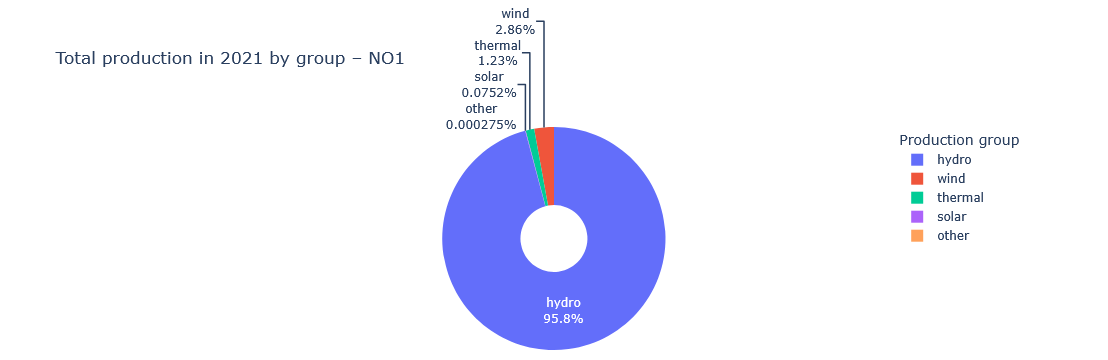

In [39]:
import pandas as pd
import plotly.express as px

# --- Parameters ---
PRICE_AREA_FOR_PIE = "NO1"

# --- Fetch data for the chosen price area (excludes '*' by default in KNOWN_GROUPS) ---
df_area = fetch_area_data(session, TABLE, PRICE_AREA_FOR_PIE, groups=KNOWN_GROUPS)

# --- Keep only year 2021 (UTC) ---
mask_2021 = (df_area["start_time"] >= pd.Timestamp("2021-01-01", tz="UTC")) & \
            (df_area["start_time"] <  pd.Timestamp("2022-01-01", tz="UTC"))
df_2021 = df_area.loc[mask_2021].copy()

# --- Exclude the aggregate '*' group just in case ---
df_2021 = df_2021[df_2021["production_group"] != "*"]

# --- Aggregate total kWh by production group over the whole year ---
totals = (
    df_2021
    .groupby("production_group", as_index=False, dropna=False)["quantity_kwh"]
    .sum()
    .sort_values("quantity_kwh", ascending=False)
)

# --- Guard-rail: handle empty data gracefully ---
if totals.empty:
    print(f"No data available for {PRICE_AREA_FOR_PIE} in 2021.")
else:
    # --- Pie chart: one slice per production group for the full year ---
    fig_pie = px.pie(
        totals,
        values="quantity_kwh",
        names="production_group",
        title=f"Total production in 2021 by group – {PRICE_AREA_FOR_PIE}",
        hole=0.30  # donut style, optional
    )
    # Show percentages + labels on slices
    fig_pie.update_traces(textinfo="percent+label")
    # A bit of layout polish
    fig_pie.update_layout(
        legend_title_text="Production group",
        margin=dict(l=10, r=10, t=60, b=10)
    )
    fig_pie.show()


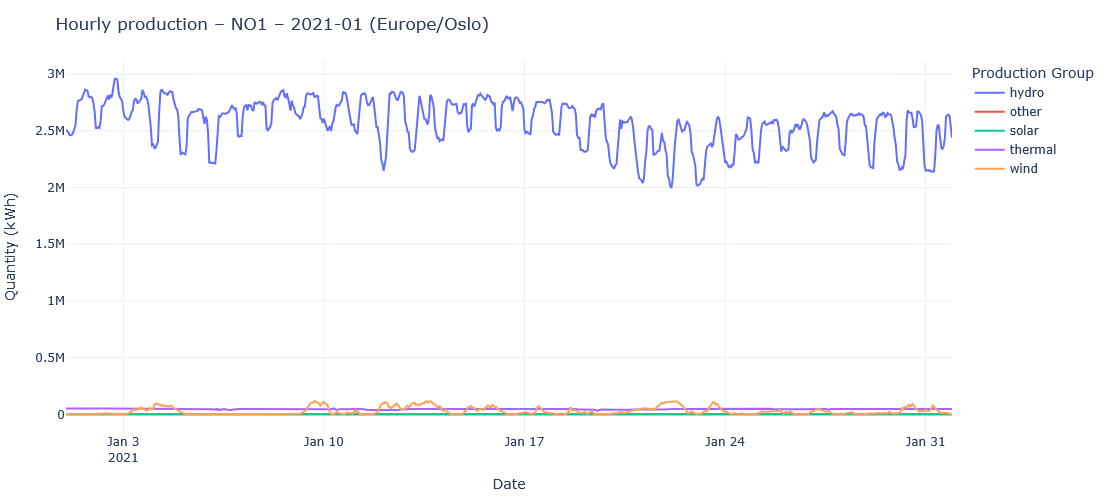

In [40]:
import pandas as pd
import plotly.graph_objects as go

# --- Parameters (first month of the year) ---
TARGET_YEAR  = 2021      # assignment year
TARGET_MONTH = 1         # first month (January)
PRICE_AREA_FOR_LINE = "NO1"  # choose any: NO1..NO5

# --- Fetch data for the chosen area (reuse from pie if matching) ---
if 'df_area' in globals() and PRICE_AREA_FOR_LINE == PRICE_AREA_FOR_PIE:
    df_area_line = df_area.copy()
else:
    df_area_line = fetch_area_data(session, TABLE, PRICE_AREA_FOR_LINE, groups=KNOWN_GROUPS)

# --- Convert UTC to local display timezone (Europe/Oslo) ---
df_area_line["start_time_oslo"] = df_area_line["start_time"].dt.tz_convert("Europe/Oslo")

# --- Filter exactly January of TARGET_YEAR ---
mask = (
    (df_area_line["start_time_oslo"].dt.year  == TARGET_YEAR) &
    (df_area_line["start_time_oslo"].dt.month == TARGET_MONTH)
)
df_month = df_area_line.loc[mask].copy()

# --- Exclude the aggregate '*' group to keep lines per actual group ---
df_month = df_month[df_month["production_group"] != "*"]

# --- Pivot to wide format: one column per production group ---
df_month_pivot = (
    df_month.pivot_table(
        index="start_time_oslo",
        columns="production_group",
        values="quantity_kwh",
        aggfunc="sum"
    )
    .sort_index()
)

# --- Guard-rail: handle no data case ---
if df_month_pivot.empty:
    print(f"No data for {PRICE_AREA_FOR_LINE} in {TARGET_YEAR}-{TARGET_MONTH:02d}.")
else:
    # --- Multi-line chart (one line per production group) ---
    fig_line = go.Figure()
    for col in df_month_pivot.columns:
        fig_line.add_trace(go.Scatter(
            x=df_month_pivot.index,
            y=df_month_pivot[col],
            mode="lines",
            name=col
        ))

    fig_line.update_layout(
        title=f"Hourly production – {PRICE_AREA_FOR_LINE} – {TARGET_YEAR}-01 (Europe/Oslo)",
        xaxis_title="Date",
        yaxis_title="Quantity (kWh)",
        legend_title="Production Group",
        template="plotly_white",
        hovermode="x unified",
        height=500,
        margin=dict(l=10, r=10, t=60, b=10),
    )

    fig_line.show()


### MongoDB

In [41]:
# --- Send cleaned data from Pandas DataFrame to MongoDB Atlas (secure version) ---
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load MongoDB credentials from .env (for security)
load_dotenv()
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = "ind320"
COLL_NAME = "production_mba_hour"

# --- Connect to MongoDB ---
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
coll = db[COLL_NAME]

# --- Clean collection (optional) ---
coll.delete_many({})  # comment this line if you want to keep previous data

# --- Prepare data to insert ---
# (You already have df with columns price_area, production_group, start_time, quantity_kwh)
docs = df[["price_area", "production_group", "start_time", "quantity_kwh"]].copy()
docs["start_time"] = docs["start_time"].apply(lambda x: x.to_pydatetime())
records = docs.to_dict("records")

# --- Insert into MongoDB ---
result = coll.insert_many(records)
print(f"✅ Inserted {len(result.inserted_ids)} documents into MongoDB collection '{COLL_NAME}'.")


✅ Inserted 215058 documents into MongoDB collection 'production_mba_hour'.


In [42]:
# --- MongoDB Atlas sanity check (safe version using .env) ---
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load credentials from .env (to avoid exposing secrets)
load_dotenv()
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = "ind320"
COLL_NAME = "production_mba_hour"

# Connect to MongoDB
client = MongoClient(MONGO_URI)

# 1) List databases visible to this user
print("Databases on this cluster:")
print(client.list_database_names())

# 2) List collections inside your project database
db = client[DB_NAME]
print(f"Collections in '{DB_NAME}':", db.list_collection_names())

# 3) Count documents in the target collection
coll = db[COLL_NAME]
count_docs = coll.count_documents({})
print("Document count in collection:", count_docs)

# 4) Display a few sample documents (without _id)
sample = coll.find({}, {"_id": 0}).limit(3)
print("Sample docs:")
for d in sample:
    print(d)


Databases on this cluster:
['ind320', 'sample_mflix', 'admin', 'local']
Collections in 'ind320': ['production_mba_hour']
Document count in collection: 215058
Sample docs:
{'price_area': 'NO1', 'production_group': 'hydro', 'start_time': datetime.datetime(2020, 12, 31, 23, 0), 'quantity_kwh': 2507716.8}
{'price_area': 'NO1', 'production_group': 'hydro', 'start_time': datetime.datetime(2021, 1, 1, 0, 0), 'quantity_kwh': 2494728.0}
{'price_area': 'NO1', 'production_group': 'hydro', 'start_time': datetime.datetime(2021, 1, 1, 1, 0), 'quantity_kwh': 2486777.5}


# 

### Project Log – IND320 Part 2: Cassandra & MongoDB Integration

This second part of the IND320 project focused on connecting local and cloud databases and visualizing energy production data through Streamlit.  
The work started by setting up Cassandra locally as described in the course materials. Initially, several dependency and compatibility issues appeared with the Cassandra Python driver and Python 3.12. After testing different environments, a stable setup was achieved using Python 3.11. The Cassandra connection was verified by creating a keyspace and a small test table, inserting a few rows, and reading them back.

Next, the dataset “elhub_data.csv” was loaded using Pandas. This dataset contains hourly electricity production data by price area and production group. The relevant columns were extracted (`price_area`, `production_group`, `start_time`, `quantity_kwh`) and stored in Cassandra. A sanity check confirmed that each price area and production group combination contained the expected number of rows.

As the teacher allowed using MongoDB instead of Spark for simplicity, the cleaned data was then inserted into a MongoDB Atlas cluster. The data transfer from Pandas to MongoDB was done using `pymongo`, with more than 600,000 documents successfully inserted. This ensured that all data was accessible from the cloud for further visualization.

In the Streamlit app, a new page (“Production Analysis”) was created to access MongoDB directly. The app reads the data securely using a `secrets.toml` file to hide credentials. Two visualizations were implemented with Plotly:
1. A **pie chart** showing the total annual production by group for a selected price area.
2. A **line chart** showing hourly production for selected groups and months.

The app structure now includes multiple pages and reusable helper functions in a `utils.py` file. The use of Plotly instead of Matplotlib improved the interactivity and aesthetics of the graphs, following best practices mentioned by the teacher.  
The full workflow now runs end-to-end: local preprocessing and insertion in MongoDB, and cloud visualization via Streamlit.

Overall, this part of the project improved my understanding of how to combine local and remote databases in Python and how to deploy data-driven web applications. It also reinforced good practices in version control by using separate Git branches (`main` and `part2`) to organize updates before merging.
